In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re

# Importing required libraries
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# from keras.layers import Embedding

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def clean_text(cmnt_text, clean_wiki_tokens = True):
    cmnt_text = cmnt_text.lower()
    #removing links
    cmnt_text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", cmnt_text)
    #removing IP addresses
    cmnt_text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", cmnt_text)
    
    if clean_wiki_tokens:
        #removing images
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", cmnt_text)
        
        #removing CSS
        cmnt_text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",cmnt_text)
        cmnt_text = re.sub(r"\{\|[^\}]*\|\}", " ", cmnt_text)
        
        #removing templates
        cmnt_text = re.sub(r"\[?\[user:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[wikipedia:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[special:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[category:.*\]", " ", cmnt_text)
        
    cmnt_text = re.sub(r"what's", "what is ", cmnt_text)
    cmnt_text = re.sub(r"\'s", " ", cmnt_text)
    cmnt_text = re.sub(r"\'ve", " have ", cmnt_text)
    cmnt_text = re.sub(r"can't", " cannot ", cmnt_text)
    cmnt_text = re.sub(r"n't", " not ", cmnt_text)
    cmnt_text = re.sub(r"i'm", " i am ", cmnt_text)
    cmnt_text = re.sub(r"\'m", " i am ", cmnt_text)
    cmnt_text = re.sub(r"\'re", " are ", cmnt_text)
    cmnt_text = re.sub(r"\'d", " would ", cmnt_text)
    cmnt_text = re.sub(r"\'ll", " will ", cmnt_text)
    cmnt_text = re.sub(r",", " ", cmnt_text)
    cmnt_text = re.sub(r"\.", " ", cmnt_text)
    cmnt_text = re.sub(r"!", " ! ", cmnt_text)
    cmnt_text = re.sub(r"\/", " ", cmnt_text)
    cmnt_text = re.sub(r"\?", " ? ", cmnt_text)
    cmnt_text = re.sub(r"\!", " ! ", cmnt_text)
    cmnt_text = re.sub(r"\"", " ", cmnt_text)
    cmnt_text = re.sub(r"\^", " ^ ", cmnt_text)
    cmnt_text = re.sub(r"\+", " + ", cmnt_text)
    cmnt_text = re.sub(r"\-", " - ", cmnt_text)
    cmnt_text = re.sub(r"\=", " = ", cmnt_text)
    cmnt_text = re.sub(r"'", " ", cmnt_text)
    cmnt_text = re.sub(r"(\d+)(k)", r"\g<1>000", cmnt_text)
    cmnt_text = re.sub(r":", " : ", cmnt_text)
    cmnt_text = re.sub(r" e g ", " eg ", cmnt_text)
    cmnt_text = re.sub(r" b g ", " bg ", cmnt_text)
    cmnt_text = re.sub(r" u s ", " american ", cmnt_text)
    cmnt_text = re.sub(r"\0s", "0", cmnt_text)
    cmnt_text = re.sub(r" 9 11 ", "911", cmnt_text)
    cmnt_text = re.sub(r"e - mail", "email", cmnt_text)
    cmnt_text = re.sub(r"j k", "jk", cmnt_text)
    cmnt_text = re.sub(r"\s{2,}", " ", cmnt_text)
    cmnt_text = re.sub(r"\n", " ", cmnt_text)
    
    stpw = stopwords.words('english')
    
    cmnt_text = " ".join([x for x in cmnt_text.split() if x not in stpw])
    
        
    return(cmnt_text)

In [3]:
def load_data():
    """
    Loads data and returns train, val, and test splits
    """
    # Load the train dataset
    df = pd.read_csv("train.csv")
    
    # Clean the text
    df['comment_text'] = df.comment_text.apply(lambda x : clean_text(x))
    
    # separate explanatory and dependent variables
    X = df.iloc[:,1]
    y = df.iloc[:,2:]

    # split for cross-validation (train-70%, validation 15% and test 15%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data()

In [5]:
bad_words = pd.read_csv("bad_words.csv")
bad_words =  list(bad_words.bad_words.values)

In [6]:
# Set Maximum number of words to be embedded
NUM_WORDS = 5000

# Define/Load Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

# Fit the function on the text
tokenizer.fit_on_texts(X_train)

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 148983 unique tokens.


In [7]:
# size of bad words
num_badwords = len(bad_words)
num_badwords

1617

In [8]:
n = 0
temp_bw = bad_words
for word, i in word_index.items():
    if word in bad_words:
        temp_bw.remove(word)
        n = n+1
    if i > (NUM_WORDS-num_badwords+n):
        for bw in temp_bw:
            tokenizer.word_index[bw] = i
            i=i+1
        break

In [9]:
# Convert train and val to sequence
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid=tokenizer.texts_to_sequences(X_val)

In [10]:
# Limit size of train/val to 50 and pad the sequence
X_train = pad_sequences(sequences_train,maxlen=50)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])

# Convert target to array
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

# Printing shape
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (111699, 50) (23936, 50)
Shape of label train and validation tensor: (111699, 6) (23936, 6)


In [11]:
embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=X_train.shape[1]))
model.add(LSTM(256))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# Compiling Model using optimizer
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 2,116,070
Trainable params: 2,116,070
Non-trainable para

In [12]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss')
callbacks_list = [early_stopping]
hist = model.fit(X_train, np.asarray(y_train), batch_size=300, epochs=20, verbose=1, 
                      validation_data=(X_val, np.asarray(y_val)),
                      callbacks=callbacks_list, shuffle=True) 

#hist = model.fit(word_seq_train, y_train, batch_size=batch_size, 
 #                epochs=num_epochs, callbacks=callbacks_list, 
#                 validation_split=0.1, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 111699 samples, validate on 23936 samples
Epoch 1/20
111699/111699 [==============================] - 423s 4ms/step - loss: 0.1012 - acc: 0.9687 - val_loss: 0.0556 - val_acc: 0.9804
Epoch 2/20
111699/111699 [==============================] - 406s 4ms/step - loss: 0.0540 - acc: 0.9807 - val_loss: 0.0526 - val_acc: 0.9814
Epoch 3/20
111699/111699 [==============================] - 414s 4ms/step - loss: 0.0503 - acc: 0.9816 - val_loss: 0.0528 - val_acc: 0.9811


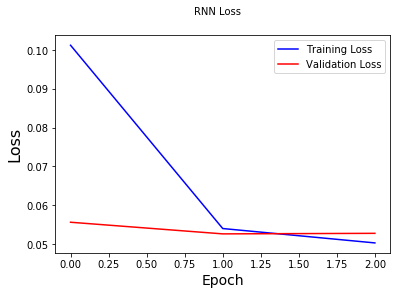

In [14]:
#plotting Loss
plt.figure()
plt.suptitle('RNN Loss', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.savefig('RNN_Loss.png', bbox_inches='tight')
plt.show()

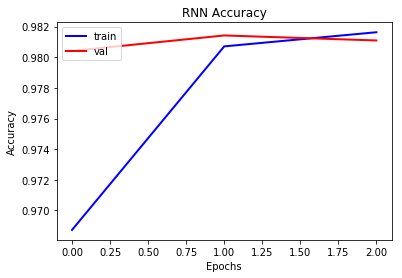

In [15]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('RNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('RNN_Accuracy.png', bbox_inches='tight')
plt.show()

In [16]:
sequences_test=tokenizer.texts_to_sequences(X_test)
X_test2 = pad_sequences(sequences_test,maxlen=X_train.shape[1])

In [17]:
# Creating empty prediction array
col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

# Predict on train, val and test datasets
pred_train = model.predict(X_train)
pred_test = model.predict(X_test2)
pred_val = model.predict(X_val)

# Emply array to collect AUC scores
AUC = np.zeros((3,6))
AUC

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [24]:
from sklearn import metrics
for i,x in enumerate(col):
    auc = np.array([metrics.roc_auc_score(y_train[:,i], pred_train[:,i]),
                    metrics.roc_auc_score(y_val[:,i], pred_val[:,i]),
                    metrics.roc_auc_score(y_test[x], pred_test[:,i])])
    print(x,"Train AUC:",auc[0],", Val AUC:",auc[1],", Test AUC:",auc[2])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Val AUC:",avg_auc[1],", Average Test AUC:",avg_auc[2])

toxic Train AUC: 0.9796179409446246 , Val AUC: 0.9653944943184282 , Test AUC: 0.9631854927365227
severe_toxic Train AUC: 0.9894768966167664 , Val AUC: 0.9870680609596691 , Test AUC: 0.9879872838411929
obscene Train AUC: 0.9904265022352358 , Val AUC: 0.985572816836823 , Test AUC: 0.9845260850587901
threat Train AUC: 0.9687573507908656 , Val AUC: 0.9459995765163627 , Test AUC: 0.9650983523714555
insult Train AUC: 0.983539129537453 , Val AUC: 0.9758937457888228 , Test AUC: 0.977551548574276
identity_hate Train AUC: 0.9699940301608341 , Val AUC: 0.9585820685496989 , Test AUC: 0.9500222514340099
Average Train AUC: 0.9803019750476301 , Average Val AUC: 0.9697517938283008 , Average Test AUC: 0.971395169002708


In [36]:
from sklearn.metrics import f1_score

for i,x in enumerate(col):
    auc = np.array([f1_score(y_train[:,i], np.round(pred_train[:,i])),
                    f1_score(y_val[:,i], np.round(pred_val[:,i])),
                    f1_score(y_test[x], np.round(pred_test[:,i]))])
    print(x,"\nTrain F1:",auc[0],", Val F1:",auc[1],", Test F1:",auc[2])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train F1:",avg_auc[0],", Average Val F1:",avg_auc[1],", Average Test F1:",avg_auc[2])

toxic 
Train F1: 0.8134030418250952 , Val F1: 0.7771639042357273 , Test F1: 0.7669481853458116
severe_toxic 
Train F1: 0.218209179834462 , Val F1: 0.16370106761565834 , Test F1: 0.23841059602649006
obscene 
Train F1: 0.8232412802972722 , Val F1: 0.8050813815005954 , Test F1: 0.8038897893030794
threat 
Train F1: 0.0 , Val F1: 0.0 , Test F1: 0.0
insult 
Train F1: 0.7273054755043228 , Val F1: 0.6927326816829579 , Test F1: 0.7119684348969749
identity_hate 
Train F1: 0.0 , Val F1: 0.0 , Test F1: 0.0
Average Train F1: 0.4303598295768587 , Average Val F1: 0.4064465058391565 , Average Test F1: 0.42020283426205934
